## Datos de partida del PERT

## Enunciado

> Se pretende construir una planta desalinizadora de agua, con el fin de proporcionar agua potable a ciertas poblaciones en las que escasea. Usted, como encargado de la planificación de la ejecución de este proyecto, decide que la descomposición en tareas y sus precedencias es la que se muestra en la tabla adjunta, donde la duración se expresa en meses.
>
> Tras un detenido análisis del proyecto en cuestión, usted ha llegado a la conclusión de que no es posible que la tarea J empece nada más terminar la tarea A, sino que es absolutamente necesario que para que se pueda empezar a ejecutar la tarea J debe de haber transcurrido un mes después de terminar la tarea A. Se pide:
>
>   1. Dibujar el diagrama PERT del proyecto y caracterícelo mediante una función Normal. 
>
>   2. Como no está conforme con la duración del proyecto que resulta, desea reducir la duración del proyecto en 1 mes con el mínimo incremento de coste posible. ¿Qué tareas deben ser reducidas?.
>
>   3. Debido al racionamiento de combustible diesel que sufre la isla, durante el proyecto sólo será posible disponer de 250 litros de gasoil cada semana; y debido a la falta de previsión de los responsables del proyecto, que no solicitaron permiso para el almacenamiento de combustible, no es posible guardar el sobrante de una semana para consumirlo la siguiente. Por otro lado las necesidades de consumo de gasoil que usted planifica son las que se muestran en la tabla. ¿Se encuentra bien nivelado el consumo de gasoil?. ¿Se encuentra bien asignado?. Si no es así ¿qué recomienda hacer para asignar correctamente el consumo de combustible?. ¿Qué consecuencias traerá la asignación correcta del combustible en este proyecto en concreto?.

In [40]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, varianza, coste,   litros, duracion_tope
  ('A',       '---',               5,        2,    '600-60t',   210,    2),
  ('B',       '---',               5,        1,    '300-20t',   150,    2),
  ('C',       'B  ',               1,        1,    '100-30t',    50,    1),
  ('D',       'B  ',               5,        1,    '300-25t',    75,    1),
  ('E',       'B  ',               2,        1,    '200-30t',    25,    1),
  ('F',       'C,D',               1,        1,    '100-10t',    75,    1),
  ('G',       'D,E',               2,        1,    '200-10t',    75,    2),
  ('H',       'E  ',               2,        1,    '150-50t',     0,    1),
  ('I',       'K  ',               4,        1,    '500-50t',   100,    3),
  ('J',       'A  ',               2,        1,    '100-10t',    50,    1),
  ('K',       'A  ',               3,        1,    '300-10t',    50,    3),
] ,columns=['actividad', 'precedentes', 'duracion', 'varianza', 'coste', 'litros', 'duracion_tope']).set_index('actividad')

datos_enunciado

,precedentes,duracion,varianza,coste,litros,duracion_tope
actividad,,,,,,
A,---,5,2,600-60t,210,2
B,---,5,1,300-20t,150,2
C,B,1,1,100-30t,50,1
D,B,5,1,300-25t,75,1
E,B,2,1,200-30t,25,1
F,"C,D",1,1,100-10t,75,1
G,"D,E",2,1,200-10t,75,2
H,E,2,1,150-50t,0,1
I,K,4,1,500-50t,100,3


## Solución
### Apartado 1


> Dibujar el diagrama PERT del proyecto y caracterícelo mediante una función Normal. 

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [41]:
from pmule import GrafoProyecto

La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

In [42]:
aristas = pd.DataFrame([
# actividad, nodo_inicial, nodo_final
  (  'A',         1,           2     ),
  (  'B',         1,           5     ),
  (  'C',         5,           8     ),
  (  'D',         5,           7     ),
  (  'E',         5,           6     ),
  (  'F',         8,           9     ),
  (  'G',         7,           9     ),
  (  'H',         6,           9     ),
  (  'I',         4,           9     ),
  (  'J',         3,           9     ),
  (  'K',         2,           4     ),
  (  'f1',        2,           3     ),
  (  'f2',        6,           7     ),
  (  'f3',        7,           8     ), 
] ,columns=['actividad', 'nodo_inicial', 'nodo_final']).set_index('actividad')

datos_proyecto = pd.concat([datos_enunciado, aristas], axis=1, sort=False).set_index(aristas.index)
datos_proyecto.loc['f1', 'duracion']=1
datos_proyecto.loc['f2', 'duracion']=0
datos_proyecto.loc['f3', 'duracion']=0

datos_proyecto

,precedentes,duracion,varianza,coste,litros,duracion_tope,nodo_inicial,nodo_final
actividad,,,,,,,,
A,---,5.0,2.0,600-60t,210.0,2.0,1,2
B,---,5.0,1.0,300-20t,150.0,2.0,1,5
C,B,1.0,1.0,100-30t,50.0,1.0,5,8
D,B,5.0,1.0,300-25t,75.0,1.0,5,7
E,B,2.0,1.0,200-30t,25.0,1.0,5,6
F,"C,D",1.0,1.0,100-10t,75.0,1.0,8,9
G,"D,E",2.0,1.0,200-10t,75.0,2.0,7,9
H,E,2.0,1.0,150-50t,0.0,1.0,6,9
I,K,4.0,1.0,500-50t,100.0,3.0,4,9


In [43]:
proyecto = GrafoProyecto(datos_proyecto)

#### Grafo PERT con numeración de nodos

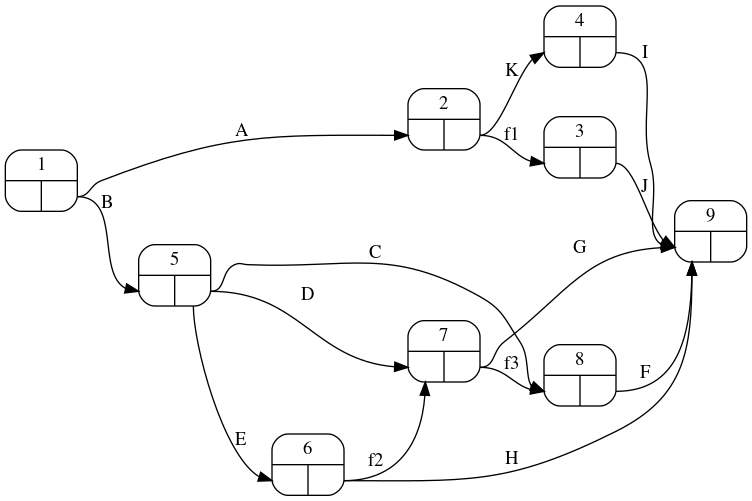

In [44]:
proyecto.pert(filename='pert_nodos_Ej_10_apartado_1.png',
              duraciones=None,
              orientation='portrait', tiempos=False, ranksep=0.5, nodesep=0.5)

#### Matriz de Zaderenko 

In [45]:
zaderenko = proyecto.zaderenko(datos_proyecto['duracion'])
zaderenko

,1,2,3,4,5,6,7,8,9,temprano
1,,5,,,5,,,,,0
2,,,1,3,,,,,,5
3,,,,,,,,,2,6
4,,,,,,,,,4,8
5,,,,,,2,5,1,,5
6,,,,,,,0,,2,7
7,,,,,,,,0,2,10
8,,,,,,,,,1,10
9,,,,,,,,,,12
tardios,0,5,10,8,5,10,10,11,12,


In [46]:
resultados_pert = proyecto.calcula_pert(duraciones=datos_proyecto['duracion'])
resultados_pert['tiempos']

,tempranos,tardios
1,0.0,0.0
5,5.0,5.0
6,7.0,10.0
7,10.0,10.0
8,10.0,11.0
2,5.0,5.0
3,6.0,10.0
4,8.0,8.0
9,12.0,12.0


In [47]:
resultados_pert['H_total']

A     0.0
B     0.0
K     0.0
f1    4.0
J     4.0
I     0.0
C     5.0
D     0.0
E     3.0
H     3.0
f2    3.0
G     0.0
f3    1.0
F     1.0
dtype: float64

In [48]:
camino_critico = proyecto.camino_critico(datos_proyecto['duracion'])
camino_critico

Index(['A', 'B', 'K', 'I', 'D', 'G'], dtype='object')

#### Grafo PERT con indicación de tiempos obtenidos de acuerdo a la planificación inicial

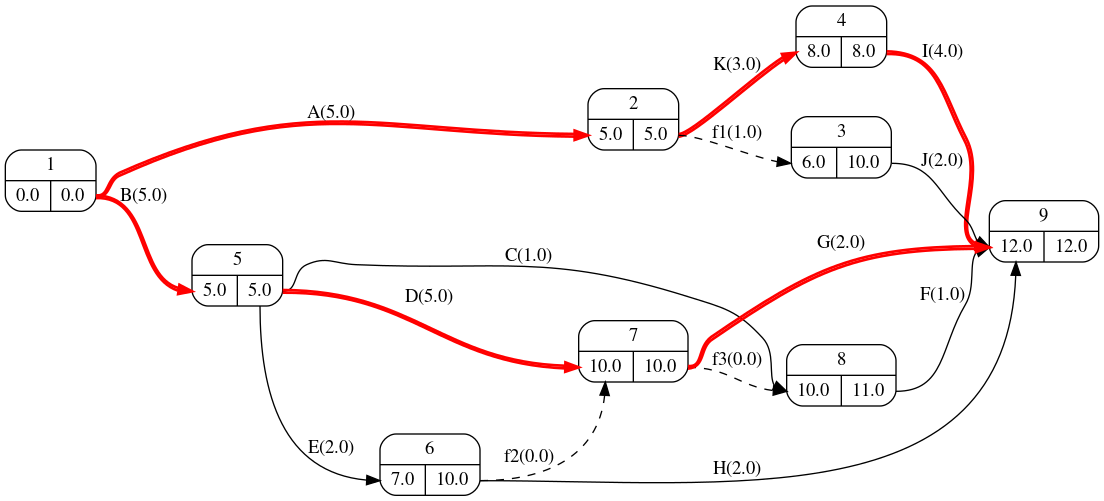

In [49]:
filename='pert_tiempos_apartado_1.png'
proyecto.pert(filename=filename,
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', ranksep=0.5, nodesep=0.5)

La duración media del proyecto ya la tenemos calculada:

In [50]:
duracion_media_proyecto = proyecto.duracion_proyecto(duraciones=datos_proyecto['duracion'])
duracion_media_proyecto

12.0

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [51]:
rama_A_K_I=['A', 'K', 'I']
rama_B_D_G=['B', 'D', 'G']
varianza_A_K_I = datos_proyecto.loc[rama_A_K_I, 'varianza'].sum()
varianza_B_D_G = datos_proyecto.loc[rama_B_D_G, 'varianza'].sum()
print('rama_A_K_I:', varianza_A_K_I )
print('rama_B_D_G:', varianza_B_D_G)

rama_A_K_I: 4.0
rama_B_D_G: 3.0


In [52]:
varianza_proyecto = max(varianza_A_K_I, varianza_B_D_G)
desviacion = varianza_proyecto ** 0.5
desviacion

2.0

El proyecto sigue una distribución normal con media 12 y desviación típica 2.

### Apartado 2

> Como no está conforme con la duración del proyecto que resulta, desea reducir la duración del proyecto en 1 mes con el mínimo incremento de coste posible. ¿Qué tareas deben ser reducidas?.

Se aborda la solución de este apartado mediante la récnica de reducción de la duración del proyecto con mínimo coste. Para ello es necesario conocer el coste unitario de reducción. No obstante, los datos del enunciado contienen la expresión del coste de reducción en función de la duración.

In [53]:
datos_proyecto['coste']

actividad
A     600-60t
B     300-20t
C     100-30t
D     300-25t
E     200-30t
F     100-10t
G     200-10t
H     150-50t
I     500-50t
J     100-10t
K     300-10t
f1        NaN
f2        NaN
f3        NaN
Name: coste, dtype: object

Para obtener el coste unitario de reducción debemos quedarnos únicamente con el coeficiente que multiplica a la variable duración 't'.

In [54]:
datos_proyecto['cur'] = ( datos_proyecto.loc[:, 'coste']
                          .str.split('[-+]', expand=True)[1]
                          .str.split('t', expand=True)[0]
                          .astype(float))
datos_proyecto['cur']

actividad
A     60.0
B     20.0
C     30.0
D     25.0
E     30.0
F     10.0
G     10.0
H     50.0
I     50.0
J     10.0
K     10.0
f1     NaN
f2     NaN
f3     NaN
Name: cur, dtype: float64

### Situación inicial de partida

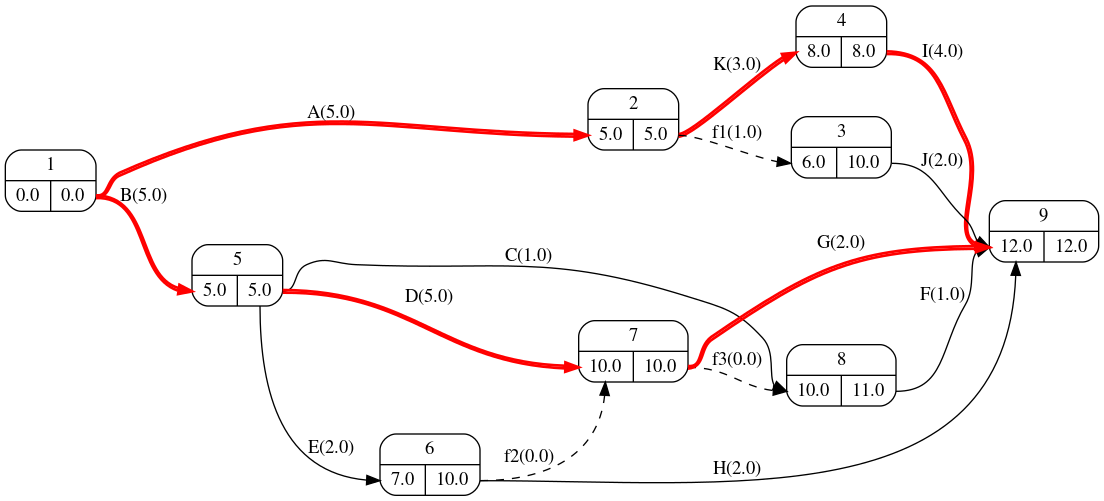

In [55]:
filename='pert_apartado_2_situacion_inicial.png'
proyecto.pert(filename=filename,
              duraciones=datos_proyecto['duracion'],
              orientation='portrait', ranksep=0.5, nodesep=0.5)

### Reducción de la duración del proyecto en un periodo

Analizamos los costes unitarios de reducción y la capacidad de reducción de cada tarea de las ramas críticas:

In [56]:
datos_proyecto.loc[rama_A_K_I, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
K,10.0,3.0,3.0
I,50.0,4.0,3.0
A,60.0,5.0,2.0


En la rama A-K-I la actividad más barata es la K, pero ya está en su duración tope. La siguiente más barata es la I, que dispone de un periodo de reducción. 

In [57]:
datos_proyecto.loc[rama_B_D_G, ['cur', 'duracion', 'duracion_tope']].sort_values(by='cur')

,cur,duracion,duracion_tope
actividad,,,
G,10.0,2.0,2.0
B,20.0,5.0,2.0
D,25.0,5.0,1.0


En la rama B-D-G la actividad más barata es la G pero ya está en su duración tope. La siguiente más barata es la B que dispone de 3 periodos de reducción.

Se propone reducir la B y la I. El coste asociado a tal reducción es:

In [58]:
datos_proyecto.loc[['B', 'I'], 'cur'].sum()

70.0

### Apartado 3. 
> Debido al racionamiento de combustible diesel que sufre la isla, durante el proyecto sólo será posible disponer de 250 litros de gasoil cada semana; y debido a la falta de previsión de los responsables del proyecto, que no solicitaron permiso para el almacenamiento de combustible, no es posible guardar el sobrante de una semana para consumirlo la siguiente. Por otro lado las necesidades de consumo de gasoil que usted planifica son las que se muestran en la tabla. ¿Se encuentra bien nivelado el consumo de gasoil?. ¿Se encuentra bien asignado?. Si no es así ¿qué recomienda hacer para asignar correctamente el consumo de combustible?. ¿Qué consecuencias traerá la asignación correcta del combustible en este proyecto en concreto?.

In [62]:
datos_proyecto['litros_por_mes'] = 4 * datos_enunciado['litros']   # Se considera el gasto mensual 4 veces el coste semanal
datos_proyecto['litros_por_mes']

actividad
A     840.0
B     600.0
C     200.0
D     300.0
E     100.0
F     300.0
G     300.0
H       0.0
I     400.0
J     200.0
K     200.0
f1      NaN
f2      NaN
f3      NaN
Name: litros_por_mes, dtype: float64

In [63]:
gantt_recursos = proyecto.gantt(duraciones=datos_proyecto['duracion'],
                                representar=datos_proyecto['litros_por_mes'],
                                total='fila',
                                holguras=True)
gantt_recursos

,1,2,3,4,5,6,7,8,9,10,11,12,H_total
A,840,840,840,840,840,,,,,,,,0
B,600,600,600,600,600,,,,,,,,0
C,,,,,,200,,,,,,,5
D,,,,,,300,300,300,300,300,,,0
E,,,,,,100,100,,,,,,3
F,,,,,,,,,,,300,,1
G,,,,,,,,,,,300,300,0
H,,,,,,,,0,0,,,,3
I,,,,,,,,,400,400,400,400,0
J,,,,,,,200,200,,,,,4


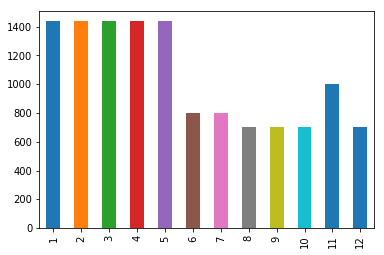

In [64]:
(gantt_recursos.data.loc['Total']
   .drop('H_total')
   .plot(kind='bar'));

La demanda del recurso no se encuantra nivelada.
Además, con el máximo disponible de 1000 litros por mes el proyecto no es ejecutable en su estado actual y debe aplicarse el algoritmo de asignación.

### Algoritmo de asignación

In [65]:
proyecto.calcula_pert(duraciones=datos_proyecto['duracion'])['H_total']

A     0.0
B     0.0
K     0.0
f1    4.0
J     4.0
I     0.0
C     5.0
D     0.0
E     3.0
H     3.0
f2    3.0
G     0.0
f3    1.0
F     1.0
dtype: float64

Durante los primeros seis periodos no es viable ejecutar A y B. Como ambas son críticas y de misma duración resulta indiferente desplazar una u otra pues en ambos casos esta acción conlleva un retraso del proyecto. Resolvemos el ejercicio desplazando la actividad B.

In [66]:
desplazamiento = proyecto.desplazar(duraciones=datos_proyecto['duracion'],
                                    actividades={'B': 5})

nuevo_gantt = desplazamiento['proyecto'].gantt(duraciones=desplazamiento['duraciones'],
                                               representar=datos_proyecto['litros_por_mes'],
                                               total='fila',
                                               holguras=True)
nuevo_gantt

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,H_total
A,840,840,840,840,840,,,,,,,,,,,,,5
B,,,,,,600,600,600,600,600,,,,,,,,0
C,,,,,,,,,,,200,,,,,,,5
D,,,,,,,,,,,300,300,300,300,300,,,0
E,,,,,,,,,,,100,100,,,,,,3
F,,,,,,,,,,,,,,,,300,,1
G,,,,,,,,,,,,,,,,300,300,0
H,,,,,,,,,,,,,0,0,,,,3
I,,,,,,,,,400,400,400,400,,,,,,5
J,,,,,,,200,200,,,,,,,,,,9


La actividad *slide_B* representa el desplazamiento de la tarea _B_. La siguiente gráfica representa la demanda de recursos tras este desplazamiento.

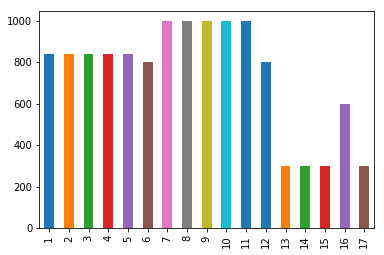

In [67]:
(nuevo_gantt
   .data
   .loc['Total']
   .drop('H_total')
   .plot(kind='bar'));

Con esta única acción la demanda de recursos del proyecto ya no supera las 1000 unidades que nos ponía de límite en el enunciado. La duración no obstante ha subido a 17 meses y el camino crítico ha cambiado.

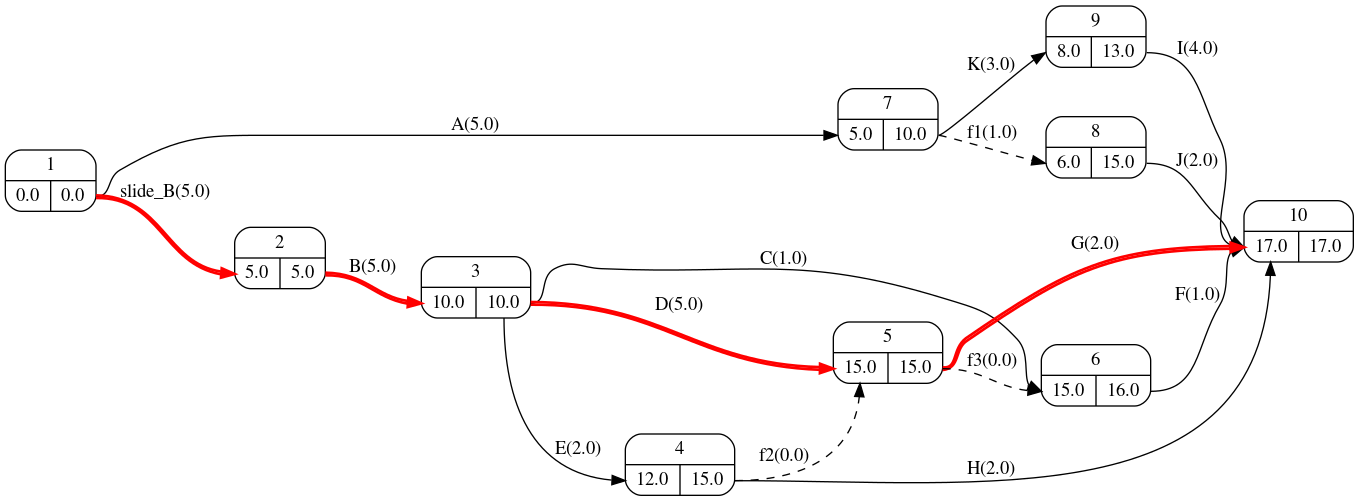

In [68]:
desplazamiento['proyecto'].pert(filename='pert_apartado_3.png',
                                duraciones=desplazamiento['duraciones'],
                                orientation='portrait', ranksep=0.5, nodesep=0.5)

In [69]:
desplazamiento['proyecto'].camino_critico(duraciones=desplazamiento['duraciones'])

Index(['slide_B', 'D', 'G', 'B'], dtype='object')